In [5]:
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology
import cv2
import numpy as np
from skimage import feature
from skimage.morphology import square

#wykrywa kolo-szukamy zarysu oczodolu na zdjeciu
#parametry ustawione sa tak, zeby wykrywac kolo o srednicy mniej wiecej rownej szerokosci/dlugosci zdjecia
def detect_circle(img):
     img2=img.copy()
     imgGray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
     min_length=min(img.shape[0],img.shape[1])
     max_length=max(img.shape[0],img.shape[1])
     minradius=int(0.5*min_length)
     #alg. HoughCircles znajduje koło na zdjęciu, na wejciu img w skali szarosci
     circles = cv2.HoughCircles(imgGray,cv2.HOUGH_GRADIENT,1,20, param1=50,param2=30,minRadius=minradius,maxRadius=int(max_length*0.5))

     if circles is not None:
         circles = np.uint16(np.around(circles))#zaokragla war. do war. calkowitych
         x=int(circles[0][0][0])
         y=int(circles[0][0][1])
         r=int(circles[0][0][2])
         if x!=0 and y!=0 and r!=0:    
            for i in circles[0,:]:
                cv2.circle(img2,(i[0],i[1]),i[2],(0,255,0),1) # rysuje koło
            #cv2.imshow('circle',img2)
            #cv2.waitKey(0)
     return circles

#sprawdza, czy dany piksel nalezy do oczodolu (true), czy do tla(false)
def in_circle(circles,w,h,less=0):
    in_c=False
    if circles is not None:
        if (circles[0][0][0]-w)**2+(circles[0][0][1]-h)**2<(circles[0][0][2]-less)**2:
            in_c=True
    return in_c

In [6]:
#rozjasnia obraz i nasyca barwe
def brightness(img):
    imgHSV=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    sumV=0
    sumS=0
    for w in range(img_width):
        for h in range(img_height):
            sumV+=imgHSV[h,w][2]
            sumS+=imgHSV[h,w][1]
    
    meanS=sumS/img_width/img_height
    meanV=sumV/img_width/img_height
    
    alfa=150/meanV
    for w in range(img_width):
        for h in range(img_height):
            imgHSV[h,w][2]=min(int(imgHSV[h,w][2]*alfa),255)

    alfa=200/meanS
    for w in range(img_width):
        for h in range(img_height):
            imgHSV[h,w][1]=min(int(imgHSV[h,w][1]*alfa),255)
    
    img2=cv2.cvtColor(imgHSV,cv2.COLOR_HSV2BGR)
    #cv2.imshow('jasniejszy', img2)
    #cv2.waitKey(0)
    return img2

#glownie ziweksza barwe zielona, dzieki czemu mamy wyrazniejsza roznice miedzy pomaranczowymi a czerwonymi pikselami
def color_filter(img,circles):
    for w in range(img_width):
        for h in range(img_height):            
            if(in_circle(circles,w,h)):
                #zwieksz lekko kolor czerwony
                img[h,w][2]=min(255,int(img[h,w][2]*1.05))
                #zwieksz barwe zielona, proporcjonalnie do jej nasycenia
                img[h,w][1]=min(int(img[h,w][1]*1.5),255)
                            
    #cv2.imshow('green_filter',img)
    #cv2.waitKey(0)
    return img

In [8]:
#wyostrza krawedzie zdjecia          
def sharpening(img):
    sh=-0.5
    kernel_sharpening = np.array([[sh,sh,sh], 
                                  [sh, abs(sh*8)+1,sh],
                                  [sh,sh,sh]])
    sharpened = cv2.filter2D(img, -1, kernel_sharpening)
    #cv2.imshow('sh',sharpened)
    #cv2.waitKey(0)
    return sharpened

#filtruje zdjecie zostawiajac kolor czerwony
def mask(img):
    imgHSV=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    
    sumS=0
    for w in range(img_width):
        for h in range(img_height):
            sumS+=imgHSV[h,w][1]
    
    meanS=int(sumS/img_width/img_height)
                
    lower_red=np.array([0,meanS,100])
    upper_red=np.array([7,255,255])
    mask1=cv2.inRange(imgHSV, lower_red,upper_red) #wybiera piksele, które są czerwone
    
    lower_red2=np.array([160,meanS,100])
    upper_red2=np.array([179,255,255])
    mask2=cv2.inRange(imgHSV, lower_red2,upper_red2)#wybiera piksele, które są czerwone
    
    mask=cv2.add(mask1,mask2)
    imgRed = cv2.bitwise_and(img, img, mask = mask)
    
    #cv2.imshow('onlyred',imgRed)
    #cv2.waitKey(0)
    return imgRed

#ustawia tło w usrednionym kolorze pikseli wewnatrz kola
def blur_background(img,circles):
    summ=0
    for w in range(img_width):
      for h in range(img_height):
          if in_circle(circles,w,h):
              summ+=img[h,w]
    
    meann=summ/(img_height*img_width)
    
    for w in range(img_width):
        for h in range(img_height):  
            if img[h,w]<0.15:
                img[h,w]=meann

    return img

In [12]:
#ustawia tło w usrednionym kolorze pikseli wewnatrz kola
def blur_background(img,circles):
    summ=0
    for w in range(img_width):
      for h in range(img_height):
          if in_circle(circles,w,h):
              summ+=img[h,w]
    
    meann=summ/(img_height*img_width)
    
    for w in range(img_width):
        for h in range(img_height):  
            if img[h,w]<0.15:
                img[h,w]=meann

    return img

#przez to, ze oczodul jest "uciety", wykrywamy 2 poziome linie oznaczajace krawedzie oczodolu
def detect_background_line(img):
    max_count1=0
    max_count2=0
    limit_down=0
    limit_up=img_height-1
    for h in range(int(img_height/2)):
        count=0
        for w in range(img_width):
            if img[h,w]:
                count+=1
        if count>max_count1:
            max_count1=count
            limit_down=h
    for h in range(int(img_height/2),img_height):
        count=0
        for w in range(img_width):
            if img[h,w]:
                count+=1
        if count>max_count2:
            max_count2=count
            limit_up=h
    return limit_down, limit_up

In [14]:
def red_pixels(red,h,w,use):
    if red[h,w][2]>50 and use:
        return True
    else:
        return False

def use_red_pixels(red):
    count=0
    for w in range(img_width):
        for h in range(img_height):
            if red_pixels(red,h,w,True):
                count+=1
    if count<200:
        return True
    else:
        return False

In [63]:
#porownuje przetworzony obraz z wzorcem, na ktorym zaznaczone sa naczynka, oblicza miary efektywnosci przetwarzania
def compare(img,template,circles,kk,image2,red_image,show): 
    tp=0
    tn=0
    fp=0
    fn=0
    red_pos=0
    red_neg=0
    use=use_red_pixels(red_image)
    for w in range(img_width):
        for h in range(img_height):            
            if(in_circle(circles,w,h,2)): #jesli piksel znajduje sie wewnatrz oczodolu
                if h>limit_down+1 and h<limit_up-1: #jesli piksel znajduje sie wewnatrz 'scietego' oczodolu
                    if img[h][w]: #piksel na przetworzonym zdjeciu jest naczynkiem
                        if template[h][w]>0.5:
                            tp+=1
                            image2[h,w]=[0,0,255]
                        else:
                            fp+=1
                            image2[h,w]=[0,255,0]
                    else:
                        if template[h][w]>0.5: 
                            if red_pixels(red_image,h,w,use):#jezeli na zdjeciu z kolorem czerwonym jest to naczynko
                                red_pos+=1
                                tp+=1
                                image2[h,w]=[0,0,255]
                            else:
                                fn+=1 
                                image2[h,w]=[255,0,0]
                        else:
                            if red_pixels(red_image,h,w,use):
                                red_neg+=1
                                fp+=1
                                image2[h,w]=[0,255,0]
                            else:
                                tn+=1
                elif template[h][w]>0.5:
                    fn+=1
            elif template[h][w]>0.5:
                fn+=1
                    
    if show:
        ax=fig.add_subplot(3, 4, kk)
        ax.axis('off')
        ax.imshow(image2)
        print('nr zdjecia: ',kk)
        print('ilosc naczynek:', round((tp+fn)/img_width/img_height*100,2),'%')
        print('tp fp fn tn:')
        print(tp, fp, fn, tn)
        print('dobrze zakwalifikowanych przypadkow: ', round((tp+tn)/(tp+tn+fp+fn),2))
        print('prezyzja',round(tp/(tp+fp),2))
        print('czulosc',round(tp/(tp+fn),2))
        print('swoistosc',round(tn/(tn+fp),2), '\n')
    
    
    return tp/(tp+fp), tp/(tp+fn), tn/(tn+fp)

In [64]:
image_list=[("eye2.jpg","eye2_1.jpg"),("eye7.jpg","eye7_1.jpg"),("eye9.jpg","eye9_1.jpg"),("eye12.jpg","eye12_1.jpg"),("eye13.jpg","eye13_1.jpg"),("eye16.jpg","eye16_1.jpg"),("eye5.jpg","eye5_1.jpg"),("eye14.jpg","eye14_1.jpg")]

mean_recall=0
mean_sensitivity=0
mean_specificity=0
plus_recall=0
plus_sensitivity=0
plus_specifity=0

nr zdjecia:  1
ilosc naczynek: 7.71 %
tp fp fn tn:
579 383 925 11278
dobrze zakwalifikowanych przypadkow:  0.9
prezyzja 0.6
czulosc 0.38
swoistosc 0.97 

nr zdjecia:  2
ilosc naczynek: 6.85 %
tp fp fn tn:
479 518 857 11104
dobrze zakwalifikowanych przypadkow:  0.89
prezyzja 0.48
czulosc 0.36
swoistosc 0.96 

nr zdjecia:  3
ilosc naczynek: 6.65 %
tp fp fn tn:
505 368 791 11415
dobrze zakwalifikowanych przypadkow:  0.91
prezyzja 0.58
czulosc 0.39
swoistosc 0.97 

nr zdjecia:  4
ilosc naczynek: 6.54 %
tp fp fn tn:
556 599 720 11827
dobrze zakwalifikowanych przypadkow:  0.9
prezyzja 0.48
czulosc 0.44
swoistosc 0.95 

nr zdjecia:  5
ilosc naczynek: 8.25 %
tp fp fn tn:
588 381 1020 10391
dobrze zakwalifikowanych przypadkow:  0.89
prezyzja 0.61
czulosc 0.37
swoistosc 0.96 

nr zdjecia:  6
ilosc naczynek: 7.63 %
tp fp fn tn:
539 608 948 11421
dobrze zakwalifikowanych przypadkow:  0.88
prezyzja 0.47
czulosc 0.36
swoistosc 0.95 

nr zdjecia:  7
ilosc naczynek: 8.69 %
tp fp fn tn:
518 902 1176 11

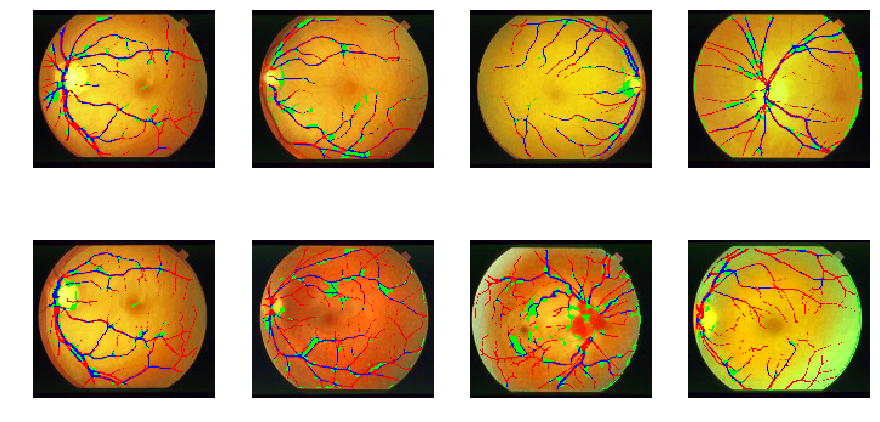

In [65]:
ii=1
plt.gray()
fig = plt.figure(figsize=(15,12))
for im, tem in image_list:
    image = cv2.imread('Image/'+im)
    img_template=cv2.imread('Image/'+tem)
    img_template = color.rgb2gray(img_template)
    img_height=image.shape[0]
    img_width=image.shape[1]
    
    image=brightness(image)   
    circles=detect_circle(image.copy())
    image=color_filter(image,circles)
    sharped=sharpening(image.copy())
    red_image=mask(sharped)
    
    #przejscie z opencv na skimage
    cv2.imwrite( "Image/image.jpg", image);         
    image=io.imread("Image/image.jpg")
    img2 = color.rgb2gray(image)
    img2=blur_background(img2, circles)
    
    #do wykrycia poziomych krawedzi oczodolu, bo z tego filtru najlepiej wykrywa
    canny = feature.canny(img2, sigma=0.5)
    limit_down,limit_up=detect_background_line(canny)
    
    #wlasciwe przetwarzanie: laplace,canny, zamkniecie, erozja
    laplace = filters.laplace(img2)
    #im mniejsza sigma, tym wiecej krawedzi wykrywa
    canny=feature.canny(laplace,sigma=0.85)
    closed=morphology.binary_closing(canny)
    eroted=morphology.binary_erosion(closed,square(3))
    
    r,sen,spec=compare(eroted,img_template,circles,ii,image.copy(),red_image,1)
    
    if ii<6: #3 ostatnie zdjecia zle wyppadaja, sa aby pokazac, kiedy algorytm sobie nie radzi
        mean_recall+=r
        mean_sensitivity+=sen
        mean_specificity+=spec
    else:
        plus_recall+=r
        plus_sensitivity+=sen
        plus_specifity+=spec
    ii+=1

ii=5
print('srednia precyzja, czulosc, swoistosc:')
print('dla dobrej jakosci zdjec (pierwsze 5):')
print(round(mean_recall/ii,2),round(mean_sensitivity/ii,2),round(mean_specificity/ii,2))
print('dla wszystkich:')
ii=8
print(round((mean_recall+plus_recall)/ii,2),round((mean_sensitivity+plus_sensitivity)/ii,2),round((mean_specificity+plus_specifity)/ii,2))

plt.show()
plt.close()